In [ ]:
!pip install tensorflow==2.12.0

# Connection to drive and path definition

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS/')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC5'

# Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr
import scipy.interpolate as interpolate
from progressbar import ProgressBar
import networkx as nx
import networkx.drawing
from collections import Counter
#from pyvis.network import Network

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
output_notebook()
from IPython.core.display import display, HTML


# Data generation

In [ ]:
parameters2 = {
        'time_delta':5,
        'interface_role':['core']
    }
interface_metrics_df = sands.generate_interface_metric_time_range(datetime.now(),datetime.now()+timedelta(hours=10),parameters2,"all",with_incidents=False)

In [ ]:
interface_metrics_df.to_csv(join(path_files,'interface_metrics_topology.csv'))

In [7]:
interface_metrics_df=pd.read_csv(join(path_files,'interface_metrics_topology.csv'),index_col=0)

In [8]:
interface_metrics_df

,timestamp,traffic_out_mbps,link_id,unique_id,device_name,interface_name,interface_type,interface_ip_address,peer_device_name,peer_interface,peer_interface_ip_address,transceiver_vendor,interface_role,traffic_in_mbps
0,1669719803,93.573037,11.1.1,C-1-et-1-1-1,C-1,et-1-1-1,400G,11.1.1.1/30,PE-1,et-1-1-1,11.1.1.2/30,Acacia,core,66.362529
1,1669719803,66.362529,11.1.1,PE-1-et-1-1-1,PE-1,et-1-1-1,400G,11.1.1.2/30,C-1,et-1-1-1,11.1.1.1/30,Acacia,core,93.573037
2,1669719803,94.275366,11.1.2,C-1-et-1-1-2,C-1,et-1-1-2,400G,11.1.2.1/30,PE-2,et-1-1-1,11.1.2.2/30,Acacia,core,66.489135
3,1669719803,66.489135,11.1.2,PE-2-et-1-1-1,PE-2,et-1-1-1,400G,11.1.2.2/30,C-1,et-1-1-2,11.1.2.1/30,Acacia,core,94.275366
4,1669719803,98.849686,11.1.3,C-1-et-1-1-3,C-1,et-1-1-3,400G,11.1.3.1/30,PE-3,et-1-1-1,11.1.3.2/30,Acacia,core,66.212120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96795,1669755803,178.469640,11.4.98,PE-98-et-1-1-4,PE-98,et-1-1-4,400G,11.4.98.2/30,C-4,et-1-1-98,11.4.98.1/30,Applied,core,136.264463
96796,1669755803,147.119556,11.4.99,C-4-et-1-1-99,C-4,et-1-1-99,400G,11.4.99.1/30,PE-99,et-1-1-4,11.4.99.2/30,Applied,core,179.083950
96797,1669755803,179.083950,11.4.99,PE-99-et-1-1-4,PE-99,et-1-1-4,400G,11.4.99.2/30,C-4,et-1-1-99,11.4.99.1/30,Applied,core,147.119556
96798,1669755803,131.854730,11.4.100,C-4-et-1-1-100,C-4,et-1-1-100,400G,11.4.100.1/30,PE-100,et-1-1-4,11.4.100.2/30,Applied,core,17.984313


# Data preparation

In [9]:
tx_df = interface_metrics_df[['unique_id','device_name','interface_name','timestamp','traffic_out_mbps']].copy()

In [10]:
rx_df = interface_metrics_df[['unique_id','device_name','interface_name','timestamp','traffic_in_mbps']].copy()

In [11]:
interface_list = tx_df['unique_id'].unique()

In [12]:
len(interface_list)

800

In [13]:
target_if = 'C-1-et-1-1-1'
mask_tx = tx_df['unique_id']==target_if
test_tx = tx_df[mask_tx][['timestamp','traffic_out_mbps']]

In [14]:
test_tx

,timestamp,traffic_out_mbps
0,1669719803,93.573037
800,1669720103,88.498028
1600,1669720403,89.885041
2400,1669720703,106.713671
3200,1669721003,100.898363
...,...,...
92800,1669754603,148.458355
93600,1669754903,153.037330
94400,1669755203,138.179295
95200,1669755503,151.957314


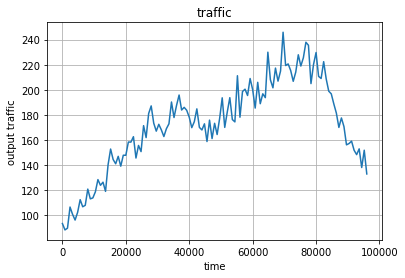

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_tx['traffic_out_mbps'])

ax.set(xlabel='time', ylabel='output traffic',
       title='traffic')
ax.grid()
plt.show()

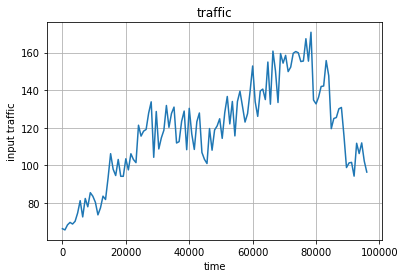

In [ ]:
mask_rx = rx_df['unique_id']==target_if
test_rx = rx_df[mask_rx][['timestamp','traffic_in_mbps']]
fig, ax = plt.subplots()
ax.plot(test_rx['traffic_in_mbps'])

ax.set(xlabel='time', ylabel='input traffic',
       title='traffic')
ax.grid()
plt.show()

In [15]:
def check_if_zero(interface):
  mask_tx = tx_df['unique_id']==interface
  mask_rx = rx_df['unique_id']==interface
  test_tx = tx_df[mask_tx][['timestamp','traffic_out_mbps']]
  test_rx = rx_df[mask_rx][['timestamp','traffic_in_mbps']]
  sum_tx = test_tx['traffic_out_mbps'].sum()
  sum_rx = test_rx['traffic_in_mbps'].sum()
  if (sum_tx + sum_rx)==0:
    return True
  else:
    return False

In [16]:
target_interface_list = []
for interface in interface_list:
  if not check_if_zero(interface):
    target_interface_list.append(interface)

In [17]:
len(target_interface_list)

800

In [18]:
SAMPLE_SIZE = 200

In [19]:
tx_vector = pd.DataFrame(np.zeros((SAMPLE_SIZE,len(target_interface_list))))
rx_vector = pd.DataFrame(np.zeros((SAMPLE_SIZE,len(target_interface_list))))

In [20]:
tx_vector.columns = target_interface_list
rx_vector.columns = target_interface_list

In [21]:
def align_samples(x1,y1,sample_size):
  x1_n = np.linspace(x1[0],x1[-1],num=sample_size, endpoint=True)
  x1_monotonic = np.linspace(x1[0],x1[-1],num=len(x1),endpoint=True)
  y1_interp = interpolate.PchipInterpolator(x1_monotonic,y1)
  y1_n = y1_interp(x1_n)
  return x1_n,y1_n

In [22]:
pbar = ProgressBar()
for interface in pbar(target_interface_list):
  mask_tx = tx_df['unique_id']==interface
  traffic_tx = tx_df[mask_tx]['traffic_out_mbps']
  traffic_tx_time = tx_df[mask_tx]['timestamp']
  mask_rx = rx_df['unique_id']==interface
  traffic_rx = rx_df[mask_rx]['traffic_in_mbps']
  traffic_tx_time_n,traffic_tx_n = align_samples(traffic_tx_time.to_numpy(),traffic_tx.to_numpy(),SAMPLE_SIZE)
  tx_vector.loc[:,interface]=traffic_tx_n
  if len(traffic_rx)>0:
    traffic_rx_time = rx_df[mask_rx]['timestamp']
    traffic_rx_time_n,traffic_rx_n = align_samples(traffic_rx_time.to_numpy(),traffic_rx.to_numpy(),SAMPLE_SIZE)
    rx_vector.loc[:,interface]=traffic_rx_n
  else:
    rx_vector.loc[:,interface]=np.zeros(SAMPLE_SIZE)

100% (800 of 800) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


In [23]:
rx_vector

,C-1-et-1-1-1,PE-1-et-1-1-1,C-1-et-1-1-2,PE-2-et-1-1-1,C-1-et-1-1-3,PE-3-et-1-1-1,C-1-et-1-1-4,PE-4-et-1-1-1,C-1-et-1-1-5,PE-5-et-1-1-1,...,C-4-et-1-1-96,PE-96-et-1-1-4,C-4-et-1-1-97,PE-97-et-1-1-4,C-4-et-1-1-98,PE-98-et-1-1-4,C-4-et-1-1-99,PE-99-et-1-1-4,C-4-et-1-1-100,PE-100-et-1-1-4
0,66.362529,93.573037,66.489135,94.275366,66.212120,98.849686,60.592667,96.166455,67.169879,96.918246,...,112.668532,85.212779,121.728883,102.644902,125.133531,88.035510,125.107079,87.474371,118.327810,94.053504
1,65.751634,89.473076,69.896408,93.926312,63.596604,98.366473,63.605532,97.054386,64.810100,98.186699,...,268.138743,86.996674,124.587325,99.663616,24.853908,88.989926,250.237853,88.892537,117.665239,89.049859
2,65.944753,88.564024,69.706280,93.994560,64.300612,96.887916,66.591537,96.496653,62.193675,98.176215,...,277.115260,87.318101,123.918750,94.975771,13.707882,89.900209,293.451050,91.954461,118.866614,89.931686
3,67.906525,89.432305,64.696677,94.957403,70.760485,93.037150,69.551696,92.033342,59.210538,96.593720,...,131.226683,86.667430,117.331212,87.834073,92.722441,90.736878,302.064447,97.795624,128.035449,100.111500
4,69.123267,96.467429,68.989857,96.294965,68.888471,93.172668,72.927029,96.667296,59.713267,99.818285,...,124.539538,88.365419,119.892936,91.699307,221.970097,96.347169,305.882840,100.845487,129.523626,99.473428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,109.881505,143.668605,104.069225,150.073380,97.882192,154.796686,105.933202,155.254109,100.734187,137.934792,...,292.821594,140.184960,124.844588,139.606842,358.904630,146.841749,178.242543,138.952175,359.503263,141.476097
196,111.265775,139.494619,100.345774,151.231320,93.930678,156.534729,101.144412,152.651651,102.723959,138.319131,...,196.061278,146.999338,193.865441,136.784240,437.415681,147.606226,179.600952,139.768940,432.302519,140.793695
197,104.340648,150.443744,99.772598,148.486191,109.928604,150.617719,89.799588,144.584341,96.390383,143.174756,...,194.760931,158.238198,181.112010,135.524184,219.774513,156.515081,192.062855,153.075190,234.573032,140.826199
198,99.619412,148.736128,96.307072,145.984510,108.869342,144.083548,90.174912,140.685155,97.485581,146.472822,...,153.938162,157.966636,179.664120,137.772141,181.738147,153.873019,191.515187,154.111356,103.072328,138.991543


# Compute Pearson correlations

In [24]:
out_correlations = pd.DataFrame(np.zeros((len(target_interface_list),len(target_interface_list))))
out_correlations.index = target_interface_list
out_correlations.columns = target_interface_list

In [28]:
out_correlations

,C-1-et-1-1-1,PE-1-et-1-1-1,C-1-et-1-1-2,PE-2-et-1-1-1,C-1-et-1-1-3,PE-3-et-1-1-1,C-1-et-1-1-4,PE-4-et-1-1-1,C-1-et-1-1-5,PE-5-et-1-1-1,...,C-4-et-1-1-96,PE-96-et-1-1-4,C-4-et-1-1-97,PE-97-et-1-1-4,C-4-et-1-1-98,PE-98-et-1-1-4,C-4-et-1-1-99,PE-99-et-1-1-4,C-4-et-1-1-100,PE-100-et-1-1-4
C-1-et-1-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PE-1-et-1-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C-1-et-1-1-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PE-2-et-1-1-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C-1-et-1-1-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PE-98-et-1-1-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C-4-et-1-1-99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PE-99-et-1-1-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C-4-et-1-1-100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    return np.maximum(np.minimum(result, 1.0), -1.0)

In [30]:
out_correlations = np_pearson_cor(tx_vector,rx_vector)

<ipython-input-29-205f7bc0a0d2>:6: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


In [31]:
out_correlations.columns=target_interface_list

In [32]:
out_correlations

,C-1-et-1-1-1,PE-1-et-1-1-1,C-1-et-1-1-2,PE-2-et-1-1-1,C-1-et-1-1-3,PE-3-et-1-1-1,C-1-et-1-1-4,PE-4-et-1-1-1,C-1-et-1-1-5,PE-5-et-1-1-1,...,C-4-et-1-1-96,PE-96-et-1-1-4,C-4-et-1-1-97,PE-97-et-1-1-4,C-4-et-1-1-98,PE-98-et-1-1-4,C-4-et-1-1-99,PE-99-et-1-1-4,C-4-et-1-1-100,PE-100-et-1-1-4
C-1-et-1-1-1,0.939494,1.000000,0.937267,0.944192,0.953678,0.941632,0.940491,0.964267,0.945848,0.966173,...,0.381113,0.951639,0.507163,0.951942,0.293490,0.957401,0.230562,0.955713,0.454919,0.953561
PE-1-et-1-1-1,1.000000,0.939494,0.913179,0.933627,0.924269,0.934692,0.913854,0.931446,0.929654,0.941695,...,0.406238,0.936274,0.453859,0.935531,0.315870,0.942022,0.204390,0.944070,0.444289,0.938268
C-1-et-1-1-2,0.933627,0.944192,0.928575,1.000000,0.929249,0.939475,0.934292,0.958244,0.929774,0.955317,...,0.366021,0.947435,0.485392,0.948012,0.286483,0.954364,0.247294,0.954386,0.453228,0.961254
PE-2-et-1-1-1,0.913179,0.937267,1.000000,0.928575,0.926773,0.943928,0.922607,0.940126,0.912080,0.940288,...,0.390335,0.927870,0.461534,0.930878,0.332791,0.938216,0.266977,0.924734,0.457754,0.931233
C-1-et-1-1-3,0.934692,0.941632,0.943928,0.939475,0.924331,1.000000,0.930334,0.943763,0.939523,0.946090,...,0.379802,0.950190,0.489241,0.957773,0.327309,0.960261,0.242804,0.944311,0.443726,0.939898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PE-98-et-1-1-4,0.315870,0.293490,0.332791,0.286483,0.290568,0.327309,0.321600,0.271917,0.245865,0.329204,...,0.197694,0.320429,0.058482,0.289387,1.000000,0.330895,0.015738,0.295431,0.103301,0.278616
C-4-et-1-1-99,0.944070,0.955713,0.924734,0.954386,0.943640,0.944311,0.935839,0.954515,0.943781,0.954053,...,0.400166,0.941033,0.486000,0.954160,0.295431,0.959983,0.226913,1.000000,0.457571,0.957906
PE-99-et-1-1-4,0.204390,0.230562,0.266977,0.247294,0.223478,0.242804,0.324839,0.256286,0.243965,0.233821,...,-0.018777,0.233699,0.161458,0.259231,0.015738,0.260095,1.000000,0.226913,0.015017,0.236008
C-4-et-1-1-100,0.938268,0.953561,0.931233,0.961254,0.944616,0.939898,0.924908,0.962656,0.933747,0.958109,...,0.369699,0.941587,0.483469,0.943089,0.278616,0.958779,0.236008,0.957906,0.482781,1.000000


In [25]:
def print_in_out(out_interface,in_interface):  
  mask_tx = tx_df['unique_id']==out_interface
  mask_rx = rx_df['unique_id']==in_interface
  test_tx = tx_df[mask_tx][['timestamp','traffic_out_mbps']]
  test_rx = rx_df[mask_rx][['timestamp','traffic_in_mbps']]
  fig, ax = plt.subplots(2,figsize=(12, 8))
  ax[0].plot(test_tx['timestamp'], test_tx['traffic_out_mbps'])
  ax[1].plot(test_rx['timestamp'], test_rx['traffic_in_mbps'])
  ax[0].set(ylabel='output traffic',
       title='output traffic')
  ax[1].set(xlabel='time', ylabel='input traffic',
       title='input traffic')
  plt.show()

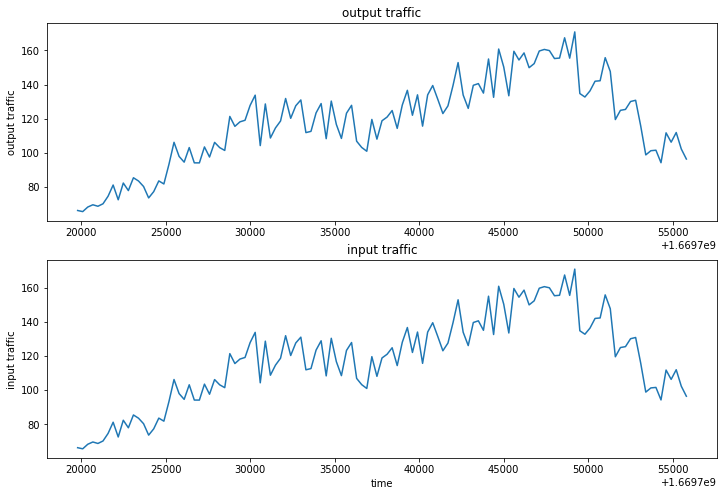

In [26]:
print_in_out(out_correlations.index[1],out_correlations.columns[0])

Text(0.5, 0, 'Data')

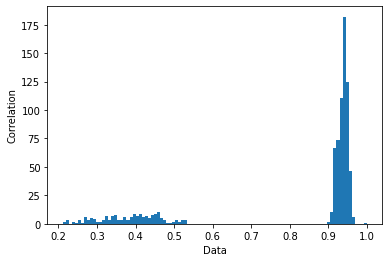

In [33]:
plt.hist(out_correlations.iloc[5,:], bins=100)  
plt.ylabel('Correlation')
plt.xlabel('Data')

# Filter and select candidates

In [34]:
top_n = 3
min_correlation = 0.9

In [35]:
top_correlations = []
for interface in target_interface_list:
  if_correlations = out_correlations.loc[interface,:]
  if_correlations.transpose()
  mask_min_correlation = if_correlations > min_correlation
  topn = if_correlations[mask_min_correlation].sort_values(ascending=False)[:top_n].index.to_list()
  for correlated_if in topn:
    device_a = interface.split('-')[0]
    device_b = correlated_if.split('-')[0]
    if device_a == device_b:
      topn.remove(correlated_if)
  top_correlations.append(topn) 

In [36]:
candidate_correlations = []
for i in range(len(target_interface_list)):
  final_candidates = []
  top_out = top_correlations[i]
  for interface in top_out:
    if target_interface_list[i] in top_correlations[target_interface_list.index(interface)]:
      final_candidates.append(interface)
  candidate_correlations.append(final_candidates)


In [37]:
len(candidate_correlations)

800

In [38]:
candidate_correlations

[['PE-1-et-1-1-1'],
 ['C-1-et-1-1-1'],
 ['PE-2-et-1-1-1'],
 ['C-1-et-1-1-2'],
 ['PE-3-et-1-1-1'],
 ['C-1-et-1-1-3'],
 ['PE-4-et-1-1-1'],
 ['C-1-et-1-1-4'],
 ['PE-5-et-1-1-1'],
 ['C-1-et-1-1-5'],
 ['PE-6-et-1-1-1'],
 ['C-1-et-1-1-6'],
 ['PE-7-et-1-1-1'],
 ['C-1-et-1-1-7'],
 ['PE-8-et-1-1-1'],
 ['C-1-et-1-1-8'],
 ['PE-9-et-1-1-1'],
 ['C-1-et-1-1-9'],
 ['PE-10-et-1-1-1'],
 ['C-1-et-1-1-10'],
 ['PE-11-et-1-1-1'],
 ['C-1-et-1-1-11'],
 ['PE-12-et-1-1-1'],
 ['C-1-et-1-1-12'],
 ['PE-13-et-1-1-1'],
 ['C-1-et-1-1-13'],
 ['PE-14-et-1-1-1'],
 ['C-1-et-1-1-14'],
 ['PE-15-et-1-1-1'],
 ['C-1-et-1-1-15'],
 ['PE-16-et-1-1-1'],
 ['C-1-et-1-1-16'],
 ['PE-17-et-1-1-1'],
 ['C-1-et-1-1-17'],
 ['PE-18-et-1-1-1'],
 ['C-1-et-1-1-18'],
 ['PE-19-et-1-1-1'],
 ['C-1-et-1-1-19'],
 ['PE-20-et-1-1-1'],
 ['C-1-et-1-1-20'],
 ['PE-21-et-1-1-1'],
 ['C-1-et-1-1-21'],
 ['PE-22-et-1-1-1'],
 ['C-1-et-1-1-22'],
 ['PE-23-et-1-1-1'],
 ['C-1-et-1-1-23'],
 ['PE-24-et-1-1-1'],
 ['C-1-et-1-1-24'],
 ['PE-25-et-1-1-1'],
 ['C-1-et-1-1

In [39]:
num_candidates=[]
for item in candidate_correlations:
  num_candidates.append(len(item))

Text(0.5, 0, 'Data')

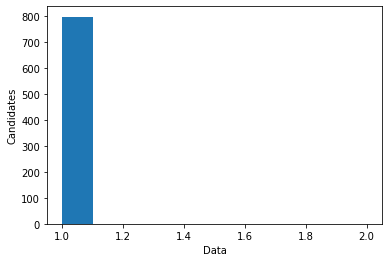

In [40]:
plt.hist(num_candidates)  # density=False would make counts
plt.ylabel('Candidates')
plt.xlabel('Data')

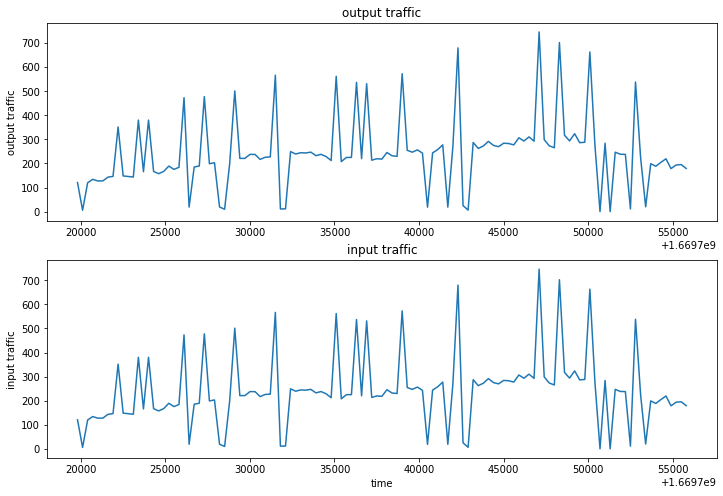

In [41]:
print_in_out(out_correlations.index[197],candidate_correlations[197][0])

# Build network graph and visualize topology

In [42]:
G=nx.Graph()

In [43]:
device_list = tx_df['device_name'].unique()

In [44]:
G.add_nodes_from(device_list)

In [45]:
for i in range(len(candidate_correlations)):
  if len(candidate_correlations[i])>0:
    node_a = target_interface_list[i].split('-')[0]+'-'+target_interface_list[i].split('-')[1]
    node_b = candidate_correlations[i][0].split('-')[0]+'-'+candidate_correlations[i][0].split('-')[1]
    G.add_edge(node_a,node_b)

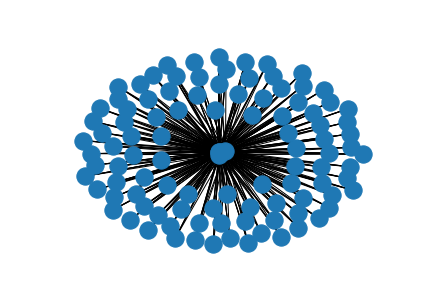

In [ ]:
nx.draw(G)

ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()


In [ ]:
title = 'My backbone network'

HOVER_TOOLTIPS = [("Device name", "@index")]


plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
network_graph = from_networkx(G, networkx.circular_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
